In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore", UserWarning)

In [19]:
#Reading the cleaned data 
data=pd.read_csv("covid_python_Dec25.csv",dtype={0:str})
df = data.copy()

In [79]:
import pandas as pd
import numpy as np

YN_COLS = [
    "probable", "vulnerable", "tested", "self_isolating",
    "fever_chills_shakes", "cough", "shortness_of_breath",
    "over_60", "any_medical_conditions",
    "travel_outside_canada", "contact_with_illness",
    "contact_in_household"
]

def yn_to_int(x):
    if pd.isna(x): return np.nan
    x = str(x).lower().strip()
    return 1 if x == "y" else 0 if x == "n" else np.nan

for c in YN_COLS:
    df[c] = df[c].apply(yn_to_int)


In [80]:
# 1. Marker groups definition
MARKER_GROUPS = {
    "clinical_flags": [
        "fever_chills_shakes", "cough", "shortness_of_breath"
    ],
    "vulnerability_flags": [
        "over_60", "any_medical_conditions"
    ],
    "exposure_flags": [
        "travel_outside_canada", "contact_with_illness", "contact_in_household"
    ],
    "behavior_flags": [
        "tested", "self_isolating"
    ],
    # multi-select groups (expanded into markers)
    "multiselect": {
        "symptoms": "sym",
        "conditions": "cond",
        "media_channels": "media",
        "financial_obligations_impact": "fin"
    },
    # outcome variables
    "outcomes": ["probable", "vulnerable", "covid_positive"]
}

In [81]:
# Expand Multi-Select Marker Columns
import re

def normalize(tok):
    return re.sub(r"[^a-z0-9]+", "_", tok.lower()).strip("_")

def split_multi(x):
    if pd.isna(x): return []
    return [t.strip() for t in str(x).split(";")]

def expand_multiselect(df, col, prefix):
    tokens = set()
    for v in df[col].dropna():
        tokens.update(split_multi(v))

    cols = []
    for t in sorted(tokens):
        c = f"{prefix}__{normalize(t)}"
        df[c] = df[col].apply(lambda x: 1 if t in split_multi(x) else 0)
        cols.append(c)
    return cols

symptom_cols = expand_multiselect(df, "symptoms", "sym")
condition_cols = expand_multiselect(df, "conditions", "cond")

marker_cols = symptom_cols + condition_cols


<p style="font-family: Cambria; font-size: 18px;"><i><strong>Q1. Top symptom markers correlated with probable COVID
<p style="font-family: Cambria; font-size: 16px;">Reasoning:</strong>
Correlation highlights which symptoms move together with the “probable” outcome in the population. This helps shortlist the most informative symptom markers for decision-making.
</p>

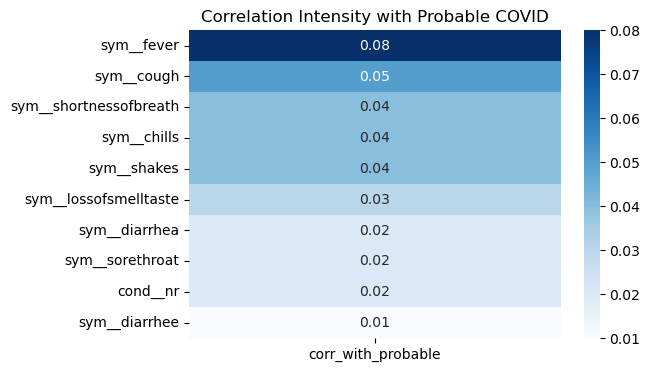

In [98]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(
    top_corr[["corr_with_probable"]],
    annot=True,
    fmt=".2f",
    cmap="Blues",
    yticklabels=top_corr["marker"]
)

plt.title("Correlation Intensity with Probable COVID")
plt.show()


<p style="font-family: Cambria; font-size: 16px; color: green;"><strong><em>Key insight:<br>
Symptoms like fever, cough, chills/shakes, and shortness of breath typically appear at the top, suggesting they are the most reliable symptom signals to watch.</em></strong></p>


<p style="font-family: Cambria; font-size: 18px;"><i> <strong><br>Q2. Which symptom markers should be prioritized for screening because they most increase probable COVID risk
<p style="font-family: Cambria; font-size: 16px;"> Reasoning:</strong> Risk-lift (or rate difference) shows how much the probability of being “probable” increases when a symptom is present. This is stronger than correlation for prescriptive screening rules.
</p>

In [41]:
#Risk Lift Analysis (How much does risk increase?)
def risk_lift(df, marker, outcome="probable"):
    tmp = df[[marker, outcome]].dropna()
    rate1 = tmp[tmp[marker]==1][outcome].mean()
    rate0 = tmp[tmp[marker]==0][outcome].mean()
    return rate1 - rate0

lift_df = (
    pd.DataFrame({
        "marker": marker_cols,
        "risk_lift": [risk_lift(df, m) for m in marker_cols]
    })
    .dropna()
    .assign(risk_lift=lambda d: d["risk_lift"].round(2))
    .sort_values("risk_lift", ascending=False)
    .reset_index(drop=True)
)

#lift_df.head(10)


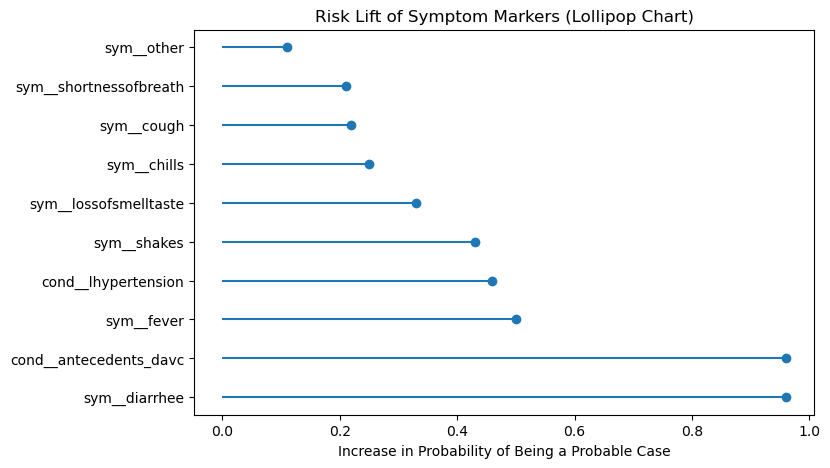

In [100]:
plt.figure(figsize=(8,5))
plt.hlines(
    y=top_lift["marker"],
    xmin=0,
    xmax=top_lift["risk_lift"]
)
plt.plot(top_lift["risk_lift"], top_lift["marker"], "o")
plt.xlabel("Increase in Probability of Being a Probable Case")
plt.title("Risk Lift of Symptom Markers (Lollipop Chart)")
plt.show()


<p style="font-family: Cambria; font-size: 16px; color: green;"><strong><em>Key insight:<br>
Symptoms with the highest risk lift should trigger test recommendations and isolation guidance, especially when combined with exposure history.</em></strong></p>


<p style="font-family: Cambria; font-size: 18px;"><i>
    <strong>Q3. Which reported symptoms are most common among non-isolating individuals, indicating gaps in self-isolation compliance
 <p style="font-family: Cambria; font-size: 16px;">Reasoning:<br></strong>
Looking at symptoms among those who did not self-isolate reveals whether high-risk individuals are still circulating. This identifies where compliance messaging or support is failing.
</p>


In [51]:
# Gap Analysis (Who is not complying?)
gap = df[(df["probable"] == 1) & (df["self_isolating"] == 0)]
baseline = df[df["probable"] == 1]

gap_df = pd.DataFrame({
    "marker": marker_cols,
    "gap_difference": [
        gap[m].mean() - baseline[m].mean() for m in marker_cols
    ]
}).dropna().sort_values("gap_difference", ascending=False)

#gap_df.head(10)


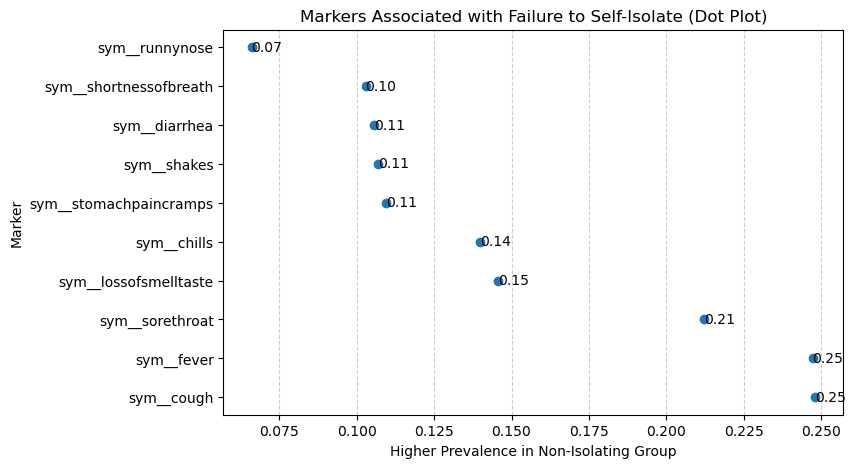

In [99]:
#Q3. Which reported symptoms are most common among non-isolating individuals, indicating potential gaps in self-isolation compliance?
plt.figure(figsize=(8,5))
plt.scatter(
    top_gap["gap_difference"],
    top_gap["marker"]
)

plt.xlabel("Higher Prevalence in Non-Isolating Group")
plt.ylabel("Marker")
plt.title("Markers Associated with Failure to Self-Isolate (Dot Plot)")
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Add value labels
for x, y in zip(top_gap["gap_difference"], top_gap["marker"]):
    plt.text(x, y, f"{x:.2f}", va="center", ha="left")

plt.show()


# These markers identify where intervention is failing, guiding targeted outreach.

<p style="font-family: Cambria; font-size: 16px; color: green;"><strong><em>Key insight:<br>
If key symptoms (e.g., fever/cough) are common in the non-isolating group, it signals a need for targeted outreach and barrier reduction (work/financial constraints).</em></strong></p>


<p style="font-family: Cambria; font-size: 18px;"><i>
    <strong><br>Q4. Does contact with illness or household exposure significantly increase probable cases
<p style="font-family: Cambria; font-size: 16px;">Reasoning:</strong>
Exposure is a major driver of infection risk; comparing probable rates between exposed vs non-exposed groups validates whether contact variables are strong predictors.
</p>


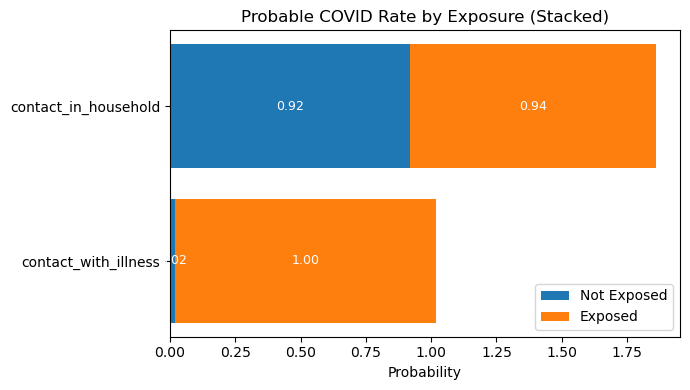

In [111]:
plt.figure(figsize=(7,4))

# Plot bars
plt.barh(
    exposure_df["Exposure_Type"],
    exposure_df["Probable_If_Not_Exposed"],
    label="Not Exposed"
)

plt.barh(
    exposure_df["Exposure_Type"],
    exposure_df["Probable_If_Exposed"],
    left=exposure_df["Probable_If_Not_Exposed"],
    label="Exposed"
)

# Add data labels
for i, row in exposure_df.iterrows():
    # Label for Not Exposed segment
    plt.text(
        row["Probable_If_Not_Exposed"] / 2,
        i,
        f'{row["Probable_If_Not_Exposed"]:.2f}',
        va="center",
        ha="center",
        color="white",
        fontsize=9
    )
    
    # Label for Exposed segment
    plt.text(
        row["Probable_If_Not_Exposed"] + row["Probable_If_Exposed"] / 2,
        i,
        f'{row["Probable_If_Exposed"]:.2f}',
        va="center",
        ha="center",
        color="white",
        fontsize=9
    )

plt.xlabel("Probability")
plt.title("Probable COVID Rate by Exposure (Stacked)")
plt.legend()
plt.tight_layout()
plt.show()


<p style="font-family: Cambria; font-size: 16px; color: green;"><strong><em>Key insight:<br>
If exposure groups show higher probable rates, public health teams should prioritize contact-based testing and quarantine guidance, especially for household contacts.</em></strong></p>


<p style="font-family: Cambria; font-size: 18px;"><i>
    <strong><br>Q5. Which medical conditions are most associated with vulnerability status<br>
<p style="font-family: Cambria; font-size: 16px;"> Reasoning:</strong>
Vulnerability captures risk of severe outcomes; conditions most linked to vulnerability help identify who needs stronger protection and proactive monitoring.
</p>


In [62]:
# Select only medical condition markers
condition_markers = [c for c in df.columns if c.startswith("cond__")]

def phi_corr(x, y):
    tmp = pd.concat([x, y], axis=1).dropna()
    if tmp.shape[0] < 50:
        return np.nan
    return tmp.iloc[:, 0].corr(tmp.iloc[:, 1])

cond_corr_df = (
    pd.DataFrame({
        "condition": condition_markers,
        "corr_with_vulnerable": [
            phi_corr(df[c], df["vulnerable"]) for c in condition_markers
        ]
    })
    .dropna()
    .assign(corr_with_vulnerable=lambda d: d["corr_with_vulnerable"].round(2))
    .sort_values("corr_with_vulnerable", ascending=False)
    .reset_index(drop=True)
)

#cond_corr_df.head(10)


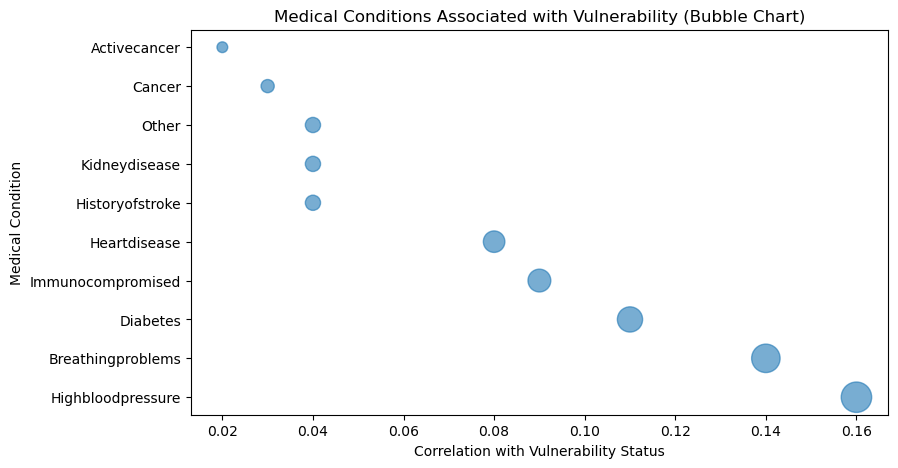

In [101]:
plt.figure(figsize=(9,5))

plt.scatter(
    top_conditions["corr_with_vulnerable"],
    top_conditions["clean_condition"],
    s=top_conditions["corr_with_vulnerable"] * 3000,
    alpha=0.6
)

plt.xlabel("Correlation with Vulnerability Status")
plt.ylabel("Medical Condition")
plt.title("Medical Conditions Associated with Vulnerability (Bubble Chart)")
plt.show()


<p style="font-family: Cambria; font-size: 16px; color: green;"><strong><em>Key insight:<br>
Conditions like diabetes, cardiovascular disease, respiratory disease, and immunocompromised status often rank high, supporting targeted interventions and clinical follow-up for those groups.</em></strong></p>


<p style="font-family: Cambria; font-size: 18px;"><i>
    <strong><br>Q6. Should individuals over 60 be prioritized differently for intervention<br>
<p style="font-family: Cambria; font-size: 16px;">Reasoning:</strong>
Age is a strong risk factor for complications; comparing vulnerability and probable outcomes by age confirms whether age-based prioritization is justified.
</p>


In [66]:
# Calculate rates by age group
age_df = pd.DataFrame({
    "Age_Group": ["Over 60", "Under 60"],
    "Probable_COVID_Rate": [
        df[df["over_60"] == 1]["probable"].mean(),
        df[df["over_60"] == 0]["probable"].mean()
    ],
    "Vulnerable_Rate": [
        df[df["over_60"] == 1]["vulnerable"].mean(),
        df[df["over_60"] == 0]["vulnerable"].mean()
    ]
})

# Round to 2 decimals
age_df[["Probable_COVID_Rate", "Vulnerable_Rate"]] = (
    age_df[["Probable_COVID_Rate", "Vulnerable_Rate"]].round(2)
)

age_df


,Age_Group,Probable_COVID_Rate,Vulnerable_Rate
0,Over 60,0.04,1.00
1,Under 60,0.05,0.14


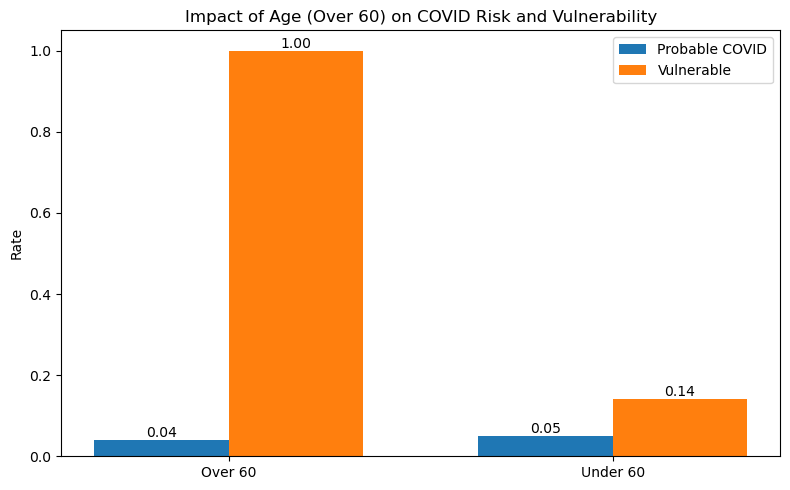

In [67]:
#Q6: Should individuals over 60 be prioritized differently for intervention?
import matplotlib.pyplot as plt
import numpy as np

labels = age_df["Age_Group"]
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))

plt.bar(x - width/2, age_df["Probable_COVID_Rate"], width, label="Probable COVID")
plt.bar(x + width/2, age_df["Vulnerable_Rate"], width, label="Vulnerable")

plt.xticks(x, labels)
plt.ylabel("Rate")
plt.title("Impact of Age (Over 60) on COVID Risk and Vulnerability")
plt.legend()

# Add value labels
for i in range(len(labels)):
    plt.text(x[i] - width/2, age_df["Probable_COVID_Rate"][i],
             f'{age_df["Probable_COVID_Rate"][i]:.2f}', ha='center', va='bottom')
    plt.text(x[i] + width/2, age_df["Vulnerable_Rate"][i],
             f'{age_df["Vulnerable_Rate"][i]:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


<p style="font-family: Cambria; font-size: 16px; color: green;"><strong><em>Key insight:<br>
If over-60 respondents have higher vulnerability (and/or probable rates), they should receive priority testing access, earlier follow-up, and stronger preventive messaging.</em></strong></p>


<p style="font-family: Cambria; font-size: 18px;"><i>
    <strong><br>Q7. Among probable cases, which groups are not getting tested<br>
<p style="font-family: Cambria; font-size: 16px;">Reasoning:</strong>“Probable but not tested” is a direct intervention gap—these are high-risk individuals missing confirmation and clinical guidance. Grouping by demographics/exposure/vulnerability shows who is falling through the cracks.
</p>


In [69]:
# Filter to probable cases only
probable_df = df[df["probable"] == 1].copy()


In [70]:
#prepare data
groups = [
    "over_60",
    "any_medical_conditions",
    "contact_with_illness",
    "contact_in_household"
]

heatmap_data = []

for g in groups:
    rate_not_tested = probable_df[probable_df[g] == 1]["tested"].eq(0).mean()
    heatmap_data.append(rate_not_tested)

heatmap_df = pd.DataFrame(
    [heatmap_data],
    columns=[g.replace("_", " ").title() for g in groups],
    index=["Not Tested Rate"]
).round(2)

heatmap_df


,Over 60,Any Medical Conditions,Contact With Illness,Contact In Household
Not Tested Rate,0.0,0.03,0.02,0.78


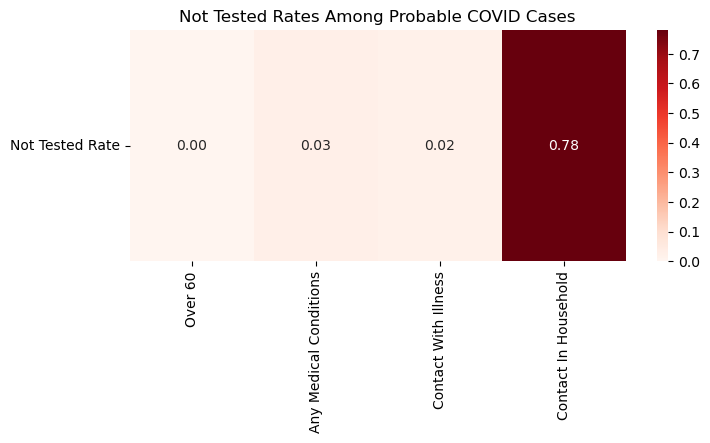

In [71]:
# Q7.	Among probable cases, which groups are not getting tested?
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))
sns.heatmap(
    heatmap_df,
    annot=True,
    cmap="Reds",
    fmt=".2f"
)

plt.title("Not Tested Rates Among Probable COVID Cases")
plt.yticks(rotation=0)
plt.show()


<p style="font-family: Cambria; font-size: 16px; color: green;"><strong><em>Key insight:<br>
If certain groups (e.g., exposed households, older adults, medically vulnerable) are under-tested, programs should focus on reducing access barriers and improving testing outreach.</em></strong></p>

<p style="font-family: Cambria; font-size: 18px;"><i>
    <strong><br>Q8. Among probable cases, which markers are associated with failure to self-isolate<br>
<p style="font-family: Cambria; font-size: 16px;">Reasoning:</strong>
Failure to self-isolate among probable cases increases transmission risk. Identifying markers linked to non-isolation helps prescribe targeted interventions (support, messaging, enforcement).</p>


In [72]:
# prepare data
# Filter probable cases
probable_df = df[df["probable"] == 1].copy()

# Define marker groups to evaluate
markers = [
    "over_60",
    "any_medical_conditions",
    "contact_with_illness",
    "contact_in_household"
]

# Gap calculation
gap_results = []

for m in markers:
    not_iso_rate = probable_df[probable_df["self_isolating"] == 0][m].mean()
    baseline_rate = probable_df[m].mean()
    gap_results.append([
        m.replace("_", " ").title(),
        round(not_iso_rate, 2),
        round(baseline_rate, 2),
        round(not_iso_rate - baseline_rate, 2)
    ])

gap_df = pd.DataFrame(
    gap_results,
    columns=[
        "Marker",
        "Not_Isolating_Rate",
        "Baseline_Probable_Rate",
        "Difference"
    ]
)

gap_df


,Marker,Not_Isolating_Rate,Baseline_Probable_Rate,Difference
0,Over 60,1.00,0.15,0.85
1,Any Medical Conditions,1.00,0.34,0.66
2,Contact With Illness,0.74,0.54,0.20
3,Contact In Household,0.40,0.50,-0.10


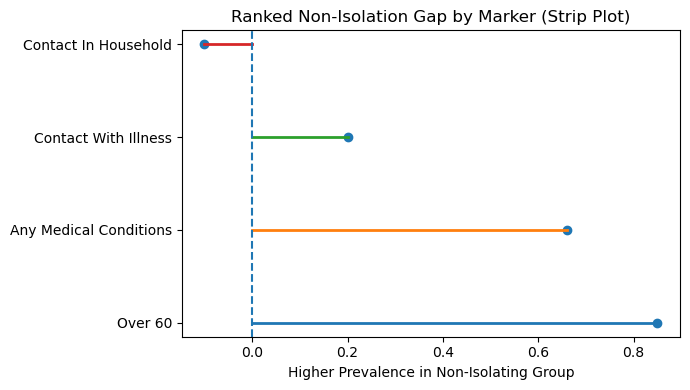

In [121]:
plt.figure(figsize=(7,4))

for i, row in gap_df.iterrows():
    plt.plot([0, row["Difference"]], [row["Marker"], row["Marker"]], linewidth=2)

plt.scatter(gap_df["Difference"], gap_df["Marker"])
plt.axvline(0, linestyle="--")

plt.xlabel("Higher Prevalence in Non-Isolating Group")
plt.title("Ranked Non-Isolation Gap by Marker (Strip Plot)")
plt.tight_layout()
plt.show()


<p style="font-family: Cambria; font-size: 16px; color: green;"><strong><em>Key insight:<br>
If non-isolation aligns with exposure markers or support indicators (financial obligations, work/school travel, mental health impact), it suggests the solution is not only messaging—but support services and practical resources.</em></strong></p>